# Pandas version of the code in "R for Marketing Research and Analytics"

## Ch 4 - Relationships between continuous variables - Customer Data

### Jupyter template stuff

In [1]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print only the last output of the cell
InteractiveShell.ast_node_interactivity = "last_expr"
# pretty print all cell's output and not just the last one
#InteractiveShell.ast_node_interactivity = "all"

In [2]:
from IPython.display import Markdown, display
def printmd(string, color=None):
    if color:
        colorstr = "<span style='color:{}'>{}</span>".format(color, string)
        display(Markdown(colorstr))
    else:
        display(Markdown(string))

#printmd("## title text")
#printmd("**bold text**")
#printmd("**bold and blue**", color="blue")

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import seaborn as sns
#import plotly.plotly as py
#import plotly
#plotly.offline.init_notebook_mode() # run at the start of every notebook
import scipy
import sklearn
from sklearn import preprocessing

# Danny, I think I will stop using statsmodels.api -- sklearn seems more mainstream
import statsmodels.api as sm # statistical modeling
import statsmodels.formula.api as smf

print(plt.style.available)
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = 8, 4

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


### Simulating Customer Data

In [4]:
# specify the seed to make test results repeatable
np.random.seed(98250)

In [5]:
ncust = 1000

df_cust = pd.DataFrame(data= {'custId': [num for num in range(ncust)],
                                    'age': np.random.normal(loc=35, scale=5, size=ncust),
                                    'email': np.random.choice(a=['yes','no'], size=ncust, replace=True, p=[0.8, 0.2]),
                                    'distanceToStore': np.exp(np.random.normal(loc=2, scale=1.2, size=ncust)) #called lognormal dist - gives all positive distances with most close, some far                                    
})

df_cust.email = df_cust.email.astype('category')

df_cust['creditScore'] = np.random.normal(loc=3*df_cust.age+620, scale=50, size=ncust)

# model online visits with negative binomial distribution w/ greater chance if we have email and lower chance with greater age
# The negative binomial distribution is a discrete distribution often used to model counts of events over time.
# Like the lognormal distribution, the negative binomial distribution generates positive values and has a long right-hand tail,
# meaning that in our data most customers make relatively few visits and a few customers make many visits.
# 
# The negative binomial distribution with size=n and prob=p represents the number of failures which occur in a sequence of 
# Bernoulli trials (e.g. coin flips) before a target number of successes is reached. 
#
# input 'n' is the number of successes, 'p' is the probability of success, and N+n is the number of trials. 
# A sample from the negative binomial distribution gives the number, N, of failures before n successes are achieved, with a success on the last trial.
# If one throws a die repeatedly until the third time a “1” appears, then the probability distribution of the number of non-“1”s that 
# appear before the third “1” is a negative binomial distribution.
#
# The mean is μ=n(1−p)/p and variance 
# is n(1−p)/p2.

# Double-checking this from a slightly different thing from wikipedia:
# Sometimes the distribution is parameterized in terms of its mean μ and variance σ2:
# p = (σ2 - μ) / σ2
# n = (μ^2) / (σ2 - μ)  # here μ^2 is the mean squared.

# The R book uses an alternative set of inputs so instead of specifying 'n' and 'p', they specify mean ('mu') and number of successes ('size')
#    in this parameterization, 'p'= size/(size+mu) and variance=mu + mu^2/size.
#    So, if the book specifies mu and size for R, I would specify as follows:
#    n=size (same parameter - i.e. the number of successes before you stop)
#    p=n/(n+mu)
n = 0.3 # it is valid to specify num<1 for n - it results in more of a right-tailed distribution
desired_mean = (15 + ((df_cust.email=='yes')*15)) - 0.7*(df_cust.age - np.median(df_cust.age))
p = n / (n + desired_mean)
df_cust['onlineVisits'] = np.random.negative_binomial(size=ncust, p=p, n=n)

# use binomial for online transactions.  This simulates the number of "heads" in "n" coin tosses, where the coin has a probability "p" of
# having a head.  The number of samples from this distribution that we pull is "size"
df_cust['onlineTransactions'] = np.random.binomial(p=0.3, n=df_cust.onlineVisits, size=ncust) # 30% probability of transaction per visit
df_cust['onlineSpend'] = np.exp(np.random.normal(size=ncust, loc=3, scale=0.1)) * df_cust.onlineTransactions

# now model physical store transactions and spend
n = 5 
desired_mean = (3 / np.sqrt(df_cust.distanceToStore))
p = n / (n + desired_mean)
df_cust['storeTransactions'] = np.random.negative_binomial(size=ncust, p=p, n=n)

df_cust['storeSpend'] = np.exp(np.random.normal(size=ncust, loc=3.5, scale=0.4)) * df_cust.storeTransactions

#--------------- Simulate satisfaction survey responses ----------------------
satOverall = pd.Series(np.random.normal(size=ncust, loc=3.1, scale=0.7))
# assuming that overall sat is not observable, but partially informs sat with service and products
# sat with service and products is measured on a discrete, ordinal scale (like "very satisfied"), we 
# convert our continuous random variables to discrete integers using floor().
satService = pd.Series(np.floor(satOverall + np.random.normal(size=ncust, loc=0.5, scale=0.4)))
satSelection = pd.Series(np.floor(satOverall + np.random.normal(size=ncust, loc=0.2, scale=0.6)))

satService[satService > 5] = 5 # enforce a ceiling here and a floor below
satService[satService < 1] = 1
satSelection[satSelection > 5] = 5
satSelection[satSelection < 1] = 1
# simulate non-response data
noResponse = pd.Series(np.random.binomial(size=ncust, n=1, p= df_cust.age/100)).astype('bool')
satService[noResponse] = np.nan
satSelection[noResponse] = np.nan

df_cust['satService'] = satService
df_cust['satSelection'] = satSelection

df_cust.sample(10)

,custId,age,email,distanceToStore,creditScore,onlineVisits,onlineTransactions,onlineSpend,storeTransactions,storeSpend,satService,satSelection
386,386,37.051332,yes,4.960512,695.764929,0,0,0.000000,0,0.000000,2.0,2.0
291,291,29.007554,yes,10.101541,702.590235,61,11,211.414480,1,54.318427,3.0,3.0
990,990,32.603116,no,5.743918,715.433860,1,0,0.000000,4,173.382214,NaN,NaN
669,669,35.413940,yes,3.895755,754.074319,1,0,0.000000,2,56.499461,NaN,NaN
705,705,28.208122,yes,13.901029,761.908873,3,1,20.462204,0,0.000000,NaN,NaN
761,761,32.229241,no,10.462033,689.280115,0,0,0.000000,1,28.707525,4.0,3.0
115,115,43.885061,yes,2.211476,739.415094,48,16,313.639924,3,99.675121,3.0,2.0
929,929,38.293543,yes,21.096426,812.890011,0,0,0.000000,2,60.641918,3.0,3.0
583,583,29.168285,yes,1.685126,725.892917,0,0,0.000000,5,154.397046,3.0,4.0
190,190,39.547260,yes,2.611565,738.123872,0,0,0.000000,2,67.680374,4.0,2.0


## Exploring Associations between variables with ScatterPlots

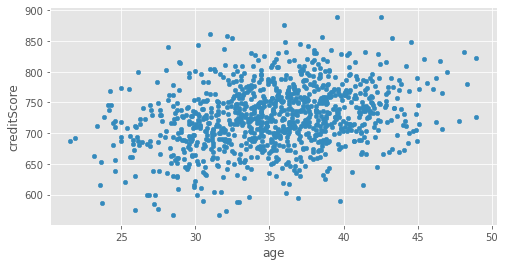

In [6]:
df_cust.plot.scatter(x='age', y='creditScore');

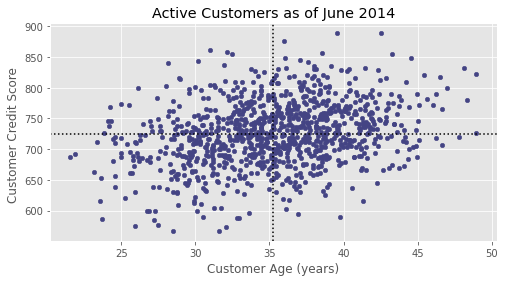

In [7]:
# same thing with better labels / options
ax = df_cust.plot.scatter(x='age', y='creditScore',
                         c='#444484',
                         title='Active Customers as of June 2014');
ax.set_xlabel('Customer Age (years)')
ax.set_ylabel('Customer Credit Score ')
ax.axhline(y=np.mean(df_cust.creditScore), color='black', linestyle=':')
ax.axvline(x=np.mean(df_cust.age), color='black', linestyle=':')

#ax.vlines(x=np.mean(df_cust.age),
#          ymin=np.min(df_cust.creditScore),
#          ymax=np.max(df_cust.creditScore),
#          colors='black',
#          linestyles='dotted')
#ax.hlines(y=np.mean(df_cust.creditScore),
#          xmin=np.min(df_cust.age),
#          xmax=np.max(df_cust.age),
#          colors='black',
#          linestyles='dotted')

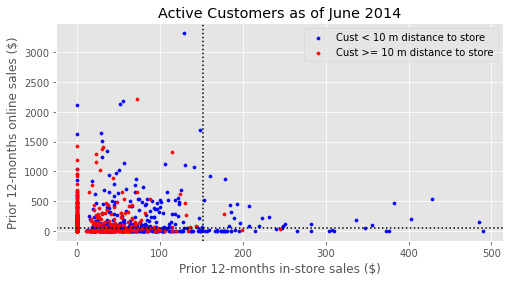

In [8]:
# look at store spend vs. offline spend
# for fun, color the customer less than 10 mile from a store different than
# customer >= 10 miles to the store.
ax = df_cust.loc[df_cust.distanceToStore<10].plot.scatter(x='storeSpend', y='onlineSpend',
                         title='Active Customers as of June 2014',
                         color='blue',
                         marker=mpl.markers.MarkerStyle(marker='o', fillstyle='none'),
                         s=10,
                         label='Cust < 10 m distance to store');
df_cust.loc[df_cust.distanceToStore>=10].plot.scatter(x='storeSpend', y='onlineSpend',
                         title='Active Customers as of June 2014',
                         color='red',
                         marker=mpl.markers.MarkerStyle(marker='o', fillstyle='none'),
                         s=10,
                         label='Cust >= 10 m distance to store',
                         ax=ax # notice this extra argument so we plot on same axis
);
ax.set_xlabel('Prior 12-months in-store sales ($)')
ax.set_ylabel('Prior 12-months online sales ($)')
ax.axhline(y=np.mean(df_cust.storeSpend), color='black', linestyle=':')
ax.axvline(x=np.mean(df_cust.onlineSpend), color='black', linestyle=':')
ax.legend();

# This is a somewhat manual way to plot different colors.  Below, we will specify
# a per-point color indexed by our email flag as an example of a more automatic 
# way

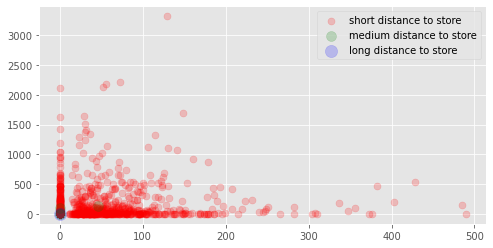

In [9]:
M = 3
sizes = [50*(i+1.) for i in range(M)]
colors = ['red', 'green', 'blue']
lab = ['short distance to store', 'medium distance to store', 'long distance to store']

bins = np.linspace(df_cust.distanceToStore.min(), df_cust.distanceToStore.max(), M)
grouped = df_cust.groupby(np.digitize(df_cust.distanceToStore, bins))
for i, (name, group) in enumerate(grouped):
    plt.scatter(group.storeSpend, group.onlineSpend,
                label=lab[i],
                color=colors[i],
                s=sizes[i],
                alpha=0.2)
plt.legend()
plt.show()

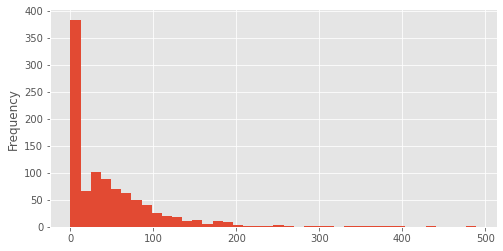

In [10]:
df_cust.storeSpend.plot.hist(bins=40);

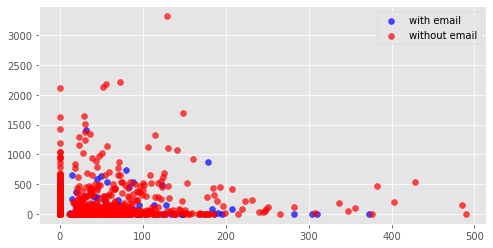

In [11]:
col = ['blue','red']
lab = ['with email', 'without email']
grouped = df_cust.groupby(df_cust.email)
for i, (name, group) in enumerate(grouped):
    plt.scatter(group.storeSpend, group.onlineSpend,
                label=lab[i],
                color=col[i],
                alpha=0.7)
plt.legend()
plt.show()

# This is a cool method, but difficult to get a legend afterwards
#ax = df_cust.plot.scatter(x='storeSpend', y='onlineSpend',
#                         title='Active Customers as of June 2014',
#                         color=df_cust.email.apply(lambda x: col[x=='yes']),
#                         marker=mpl.markers.MarkerStyle(marker='o', fillstyle='none'),
#                         s=10);

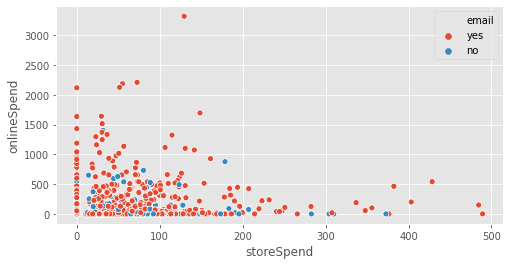

In [12]:
# This is much simpler using seaborn...
ax = sns.scatterplot(x='storeSpend', y='onlineSpend', data=df_cust, hue='email') # could have also said style='email' or size='email'

### Plotting on a Log Scale

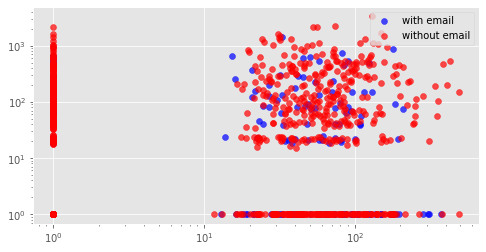

In [13]:
# Plot on a log scale.  Note that we must add +1 to values so we have no zeros
# since log(0) is undefined
col = ['blue','red']
lab = ['with email', 'without email']
grouped = df_cust.groupby(df_cust.email)
for i, (name, group) in enumerate(grouped):
    plt.scatter(group.storeSpend+1, group.onlineSpend+1,
                label=lab[i],
                color=col[i],
                alpha=0.7)
plt.loglog() # this sets both axes to log (this is in the pyplot API)
plt.legend()
plt.show()

[None]

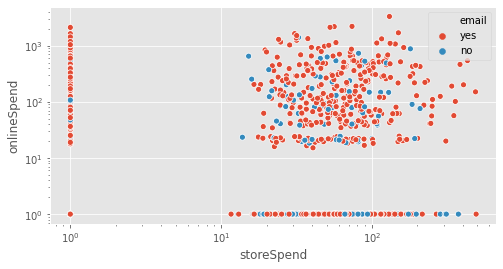

In [14]:
# This is much simpler using seaborn...
df_copy = df_cust.copy()
df_copy.storeSpend = df_copy.storeSpend +1
df_copy.onlineSpend = df_copy.onlineSpend +1

ax = sns.scatterplot(x='storeSpend', y='onlineSpend', data=df_copy, hue='email') 
ax.set(xscale='log')
ax.set(yscale='log')

/home/danielayoung/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/danielayoung/py3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


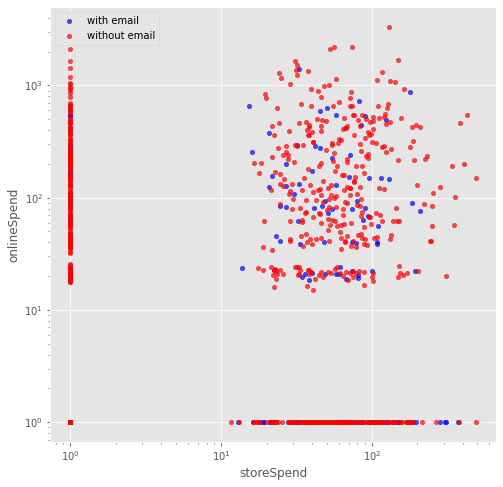

In [15]:
# also show how to do this using the pandas .plot.scatter()
# instead of the matplotlib plt.scatter()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))     # returns fig and array of axes (3 of them in this case)
col = ['blue','red']
lab = ['with email', 'without email']
grouped = df_cust.groupby(df_cust.email)
for i, (name, group) in enumerate(grouped):
    group['storeSpend'] = group.storeSpend+1   # do this to prevent error since log(0) is undefined
                                               # this is one a view, so won't overwrite the original value
    group['onlineSpend'] = group.onlineSpend+1
    group.plot.scatter(x='storeSpend', y='onlineSpend',
                      label = lab[i],
                      color = col[i],
                      alpha = 0.7,
                      logx=True, logy=True,
                      ax=axes)
#    plt.scatter(group.storeSpend, group.onlineSpend,
#                label=lab[i],
#                color=col[i],
#                alpha=0.7,
#                logx=True, logy=True)
axes.legend()


### Combining Plots in a Single Graphics Object

Text(0, 0.5, 'onlineSpend +1')

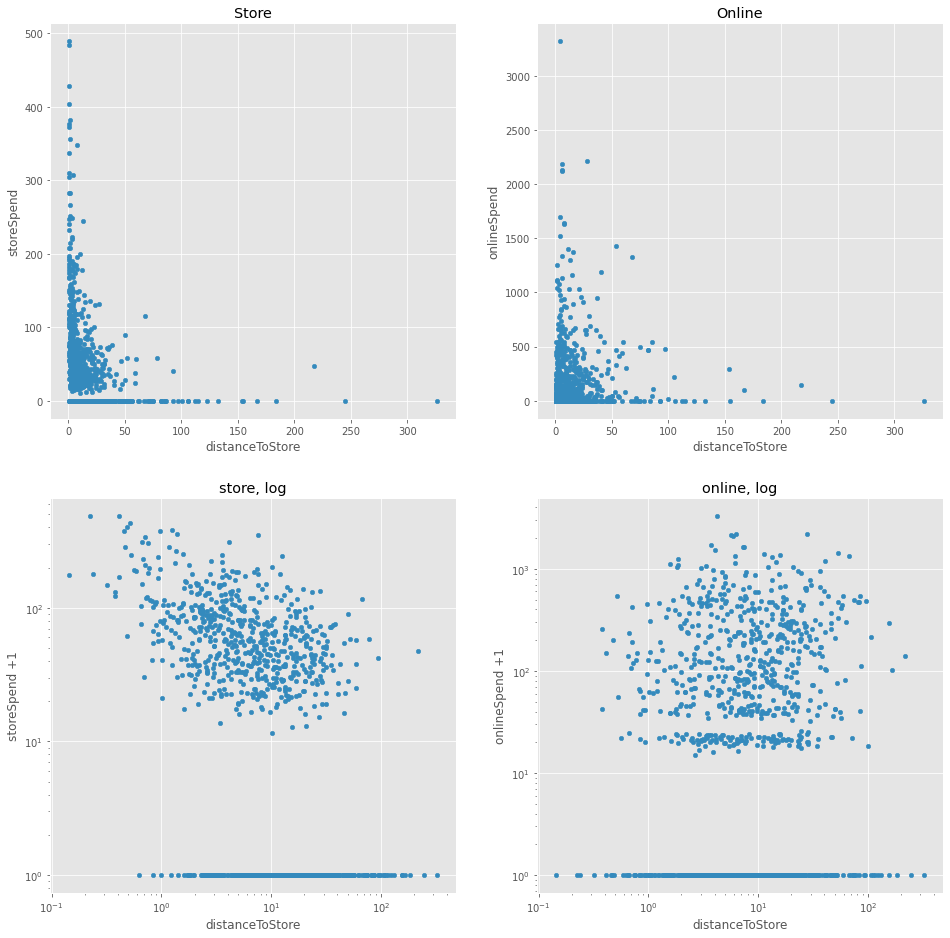

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2,
                            sharex=False, sharey=False,
                            figsize=(16, 16))     # returns fig and array of axes
df_copy = df_cust.copy()
df_copy.storeSpend = df_copy.storeSpend +1
df_copy.onlineSpend = df_copy.onlineSpend +1
df_cust.plot.scatter(x='distanceToStore', y='storeSpend', title='Store', ax=axes[0][0])
df_cust.plot.scatter(x='distanceToStore', y='onlineSpend', title='Online', ax=axes[0][1])
df_copy.plot.scatter(x='distanceToStore', y='storeSpend', title='store, log', ax=axes[1][0], logx=True, logy=True)
axes[1][0].set_ylabel('storeSpend +1')
df_copy.plot.scatter(x='distanceToStore', y='onlineSpend', title='online, log', ax=axes[1][1], logx=True, logy=True)
axes[1][1].set_ylabel('onlineSpend +1')

## Scatterplot Matrices

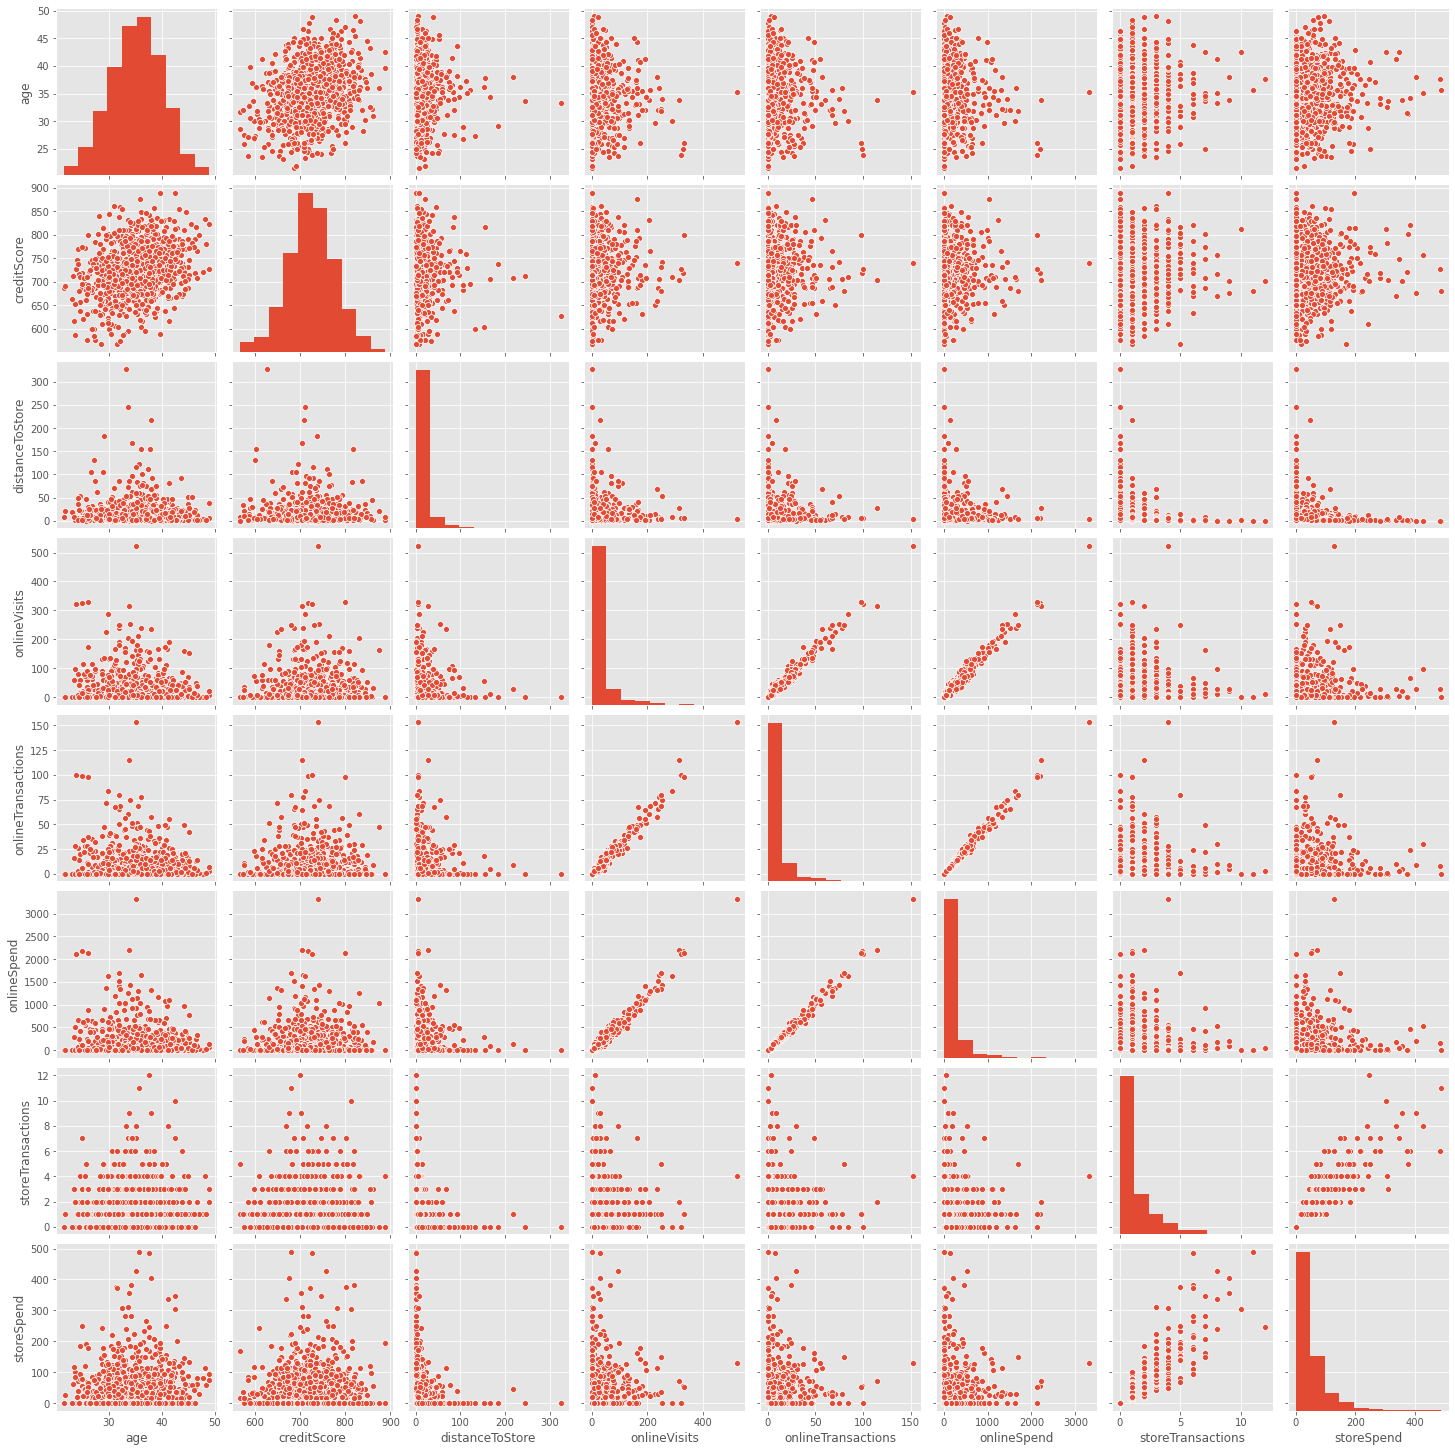

In [17]:
# Let's use seaborn...
sns.pairplot(data=df_cust.loc[:,['age', 'creditScore', 'email', 'distanceToStore',
                                'onlineVisits', 'onlineTransactions', 'onlineSpend',
                                'storeTransactions', 'storeSpend']])
# Note that even though I specified 'email', it didn't include it because it is a categorical variable.

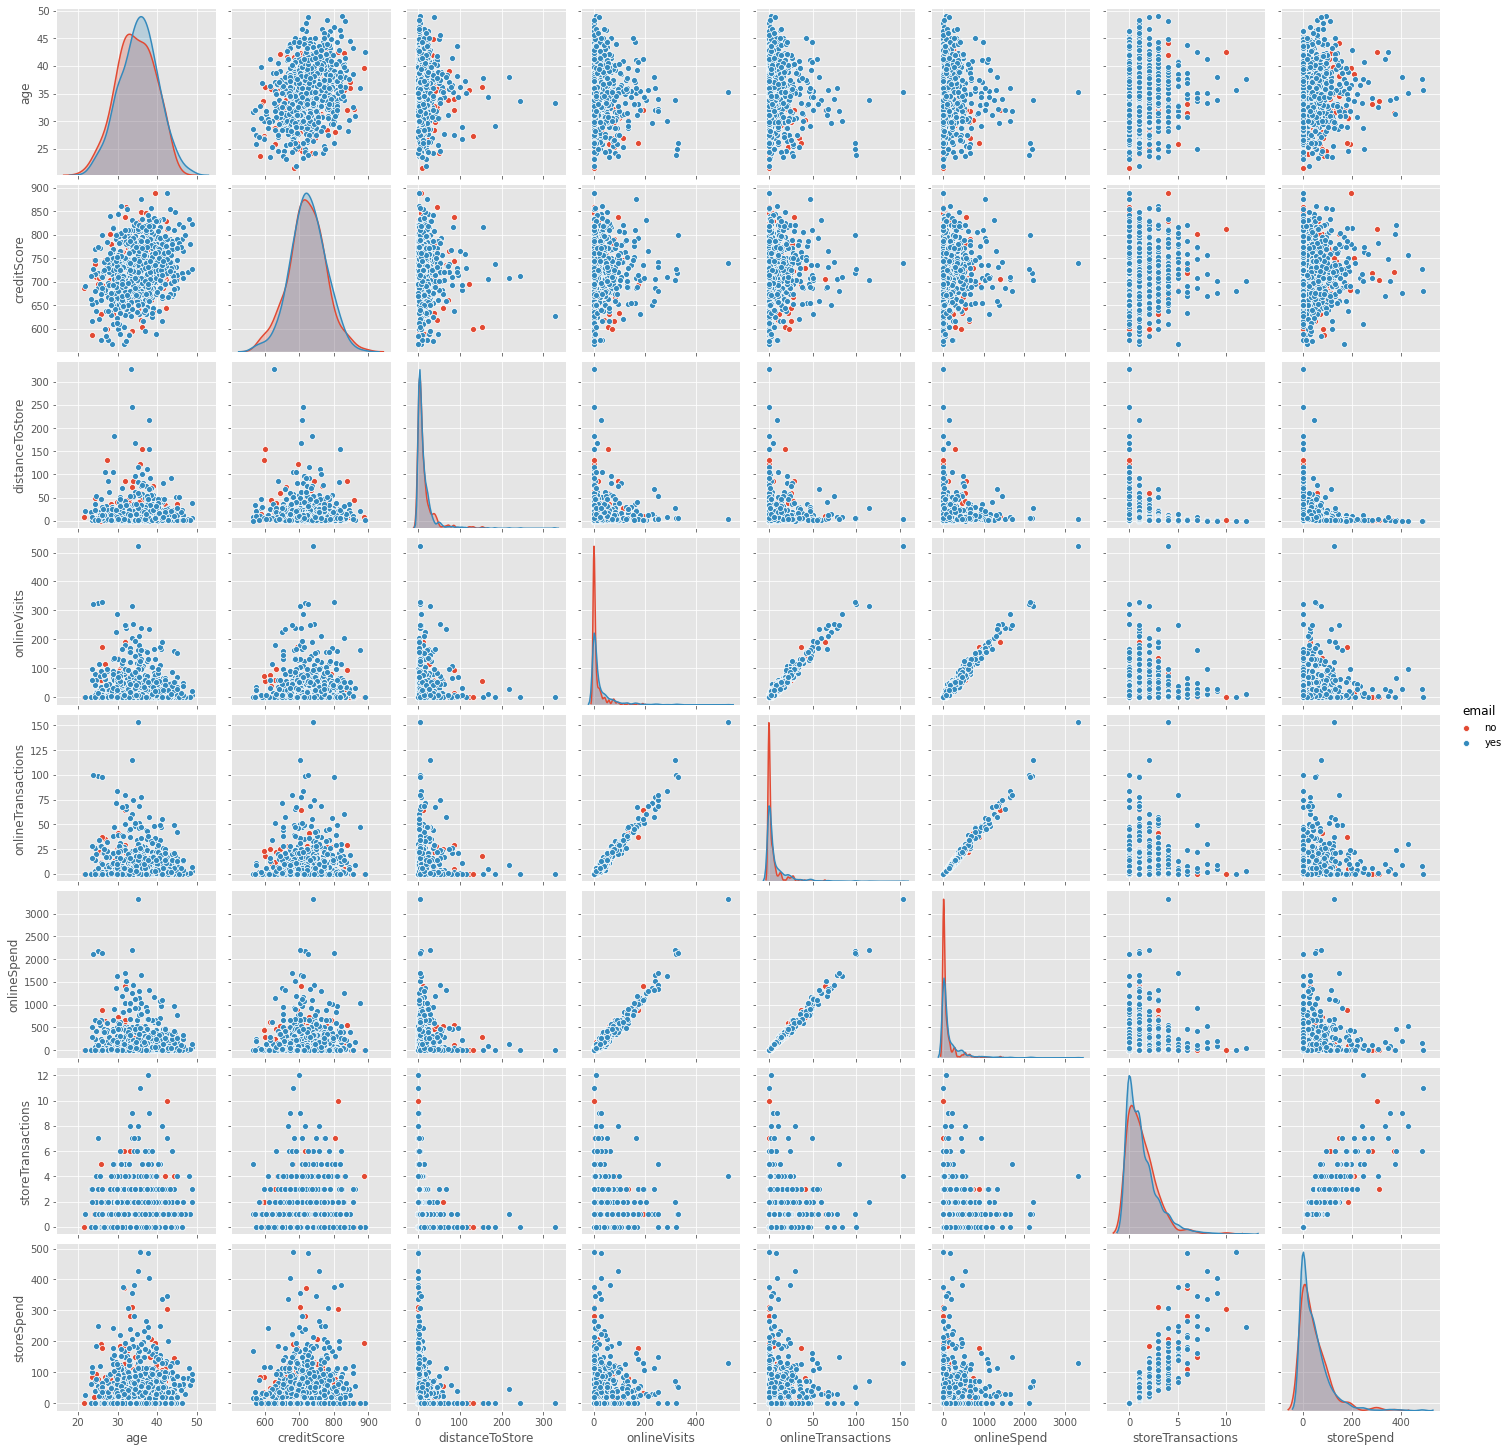

In [18]:
# same thing but use 'email' as a hue in each
sns.pairplot(data=df_cust.loc[:,['age', 'creditScore', 'email', 'distanceToStore',
                                'onlineVisits', 'onlineTransactions', 'onlineSpend',
                                'storeTransactions', 'storeSpend']], hue='email')

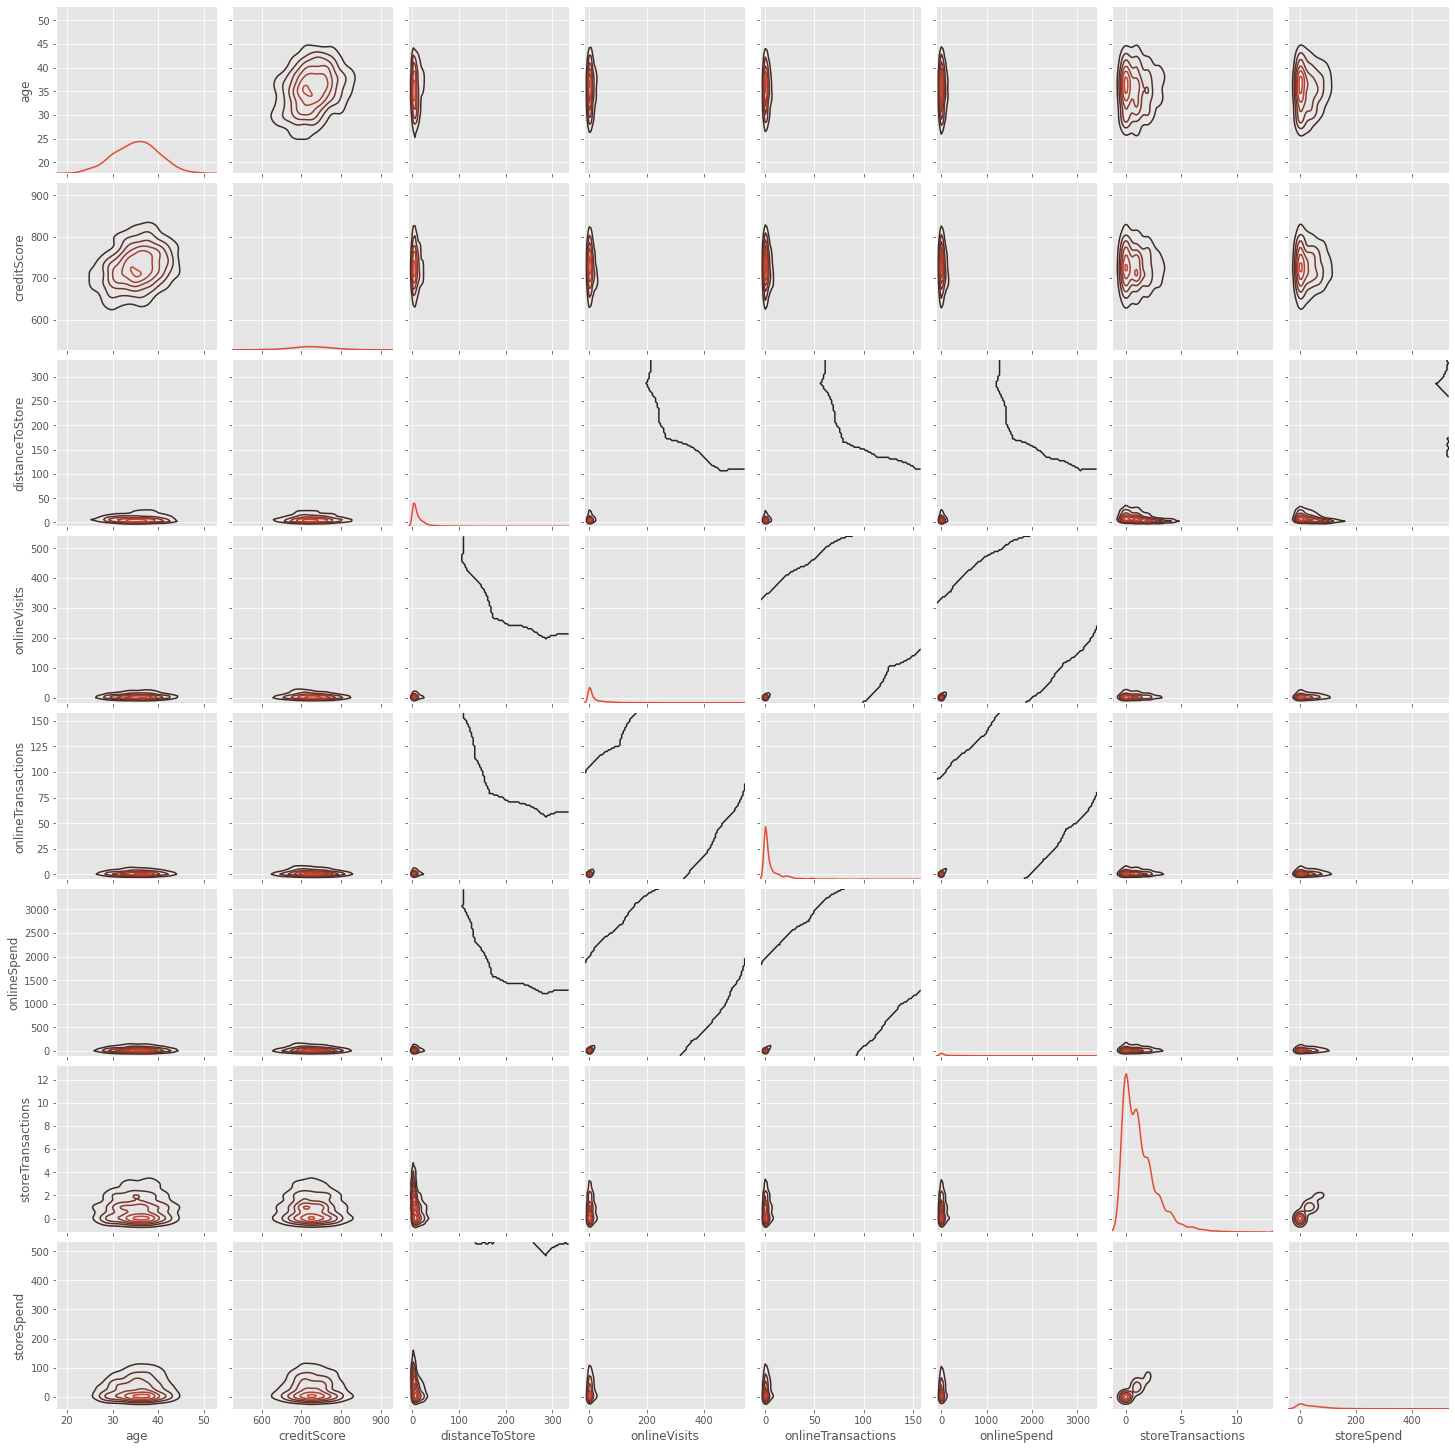

In [19]:
# use PairGrid instead for more fine-grained control...
g = sns.PairGrid(data=df_cust.loc[:,['age', 'creditScore', 'email', 'distanceToStore',
                                'onlineVisits', 'onlineTransactions', 'onlineSpend',
                                'storeTransactions', 'storeSpend']])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

## Correlation Coefficients

In [20]:
np.cov(m=df_cust.age, y=df_cust.creditScore)
# Note that this is hard to interpret because it depends on the scales
# of the two variables.
# The Pearson Correlation Coefficient is on a standardized scale, so we
# use it instead (next cell)

array([[  23.25311065,   73.90165825],
       [  73.90165825, 2713.88446081]])

In [21]:
np.corrcoef(df_cust.age, df_cust.creditScore)
np.corrcoef(df_cust.age, df_cust.creditScore)[0][1]

0.2941832741567698

In [22]:
# this correlation coefficient is the same as scaling the covariance by 
# the joint standard deviations:
np.cov(df_cust.age, df_cust.creditScore)[0][1] / (np.std(df_cust.age)*np.std(df_cust.creditScore))

0.29447775190867836

 In physical sciences, you might look for correlation coefficients of 0.9 or 0.95.  In social sciences like marketing, **Cohen's Rules of Thumb** says r = 0.1 is small or weak, r=0.3 is medium strength, and r=0.5 is a strong effect (i.e. noticable by casual observer).  However, this rule of thumb only applies if the variables are **normally distributed**.  If not, we may have to transform the variables first (this is covered later)

### Correlation Test
Is the correlation statistically significant?  Use Pearson's product-moment correlation test to find out

In [23]:
xtest = np.array([40,600,60,72,400,90,200,70,80,84])
ytest = np.array([3.5,25.0,4.8,3.5,30.0,5.0,12.0,4.5,5.0,6.0])
r, p = scipy.stats.pearsonr(xtest, ytest)
print('The pearson correlation coefficient is {}.  The probability of an uncorrelated set producing this corr coeff is {}'.format(r,p))

The pearson correlation coefficient is 0.9268235988521282.  The probability of an uncorrelated set producing this corr coeff is 0.00011476416702895263


In [24]:
#In the case of our data, run this test on age vs. credit score:
r, p = scipy.stats.pearsonr(df_cust.age, df_cust.creditScore)
print('corr coeff = {}\np = {}'.format(r,p))

corr coeff = 0.2941832741567699
p = 2.052841635723008e-21


Correlation Matrices

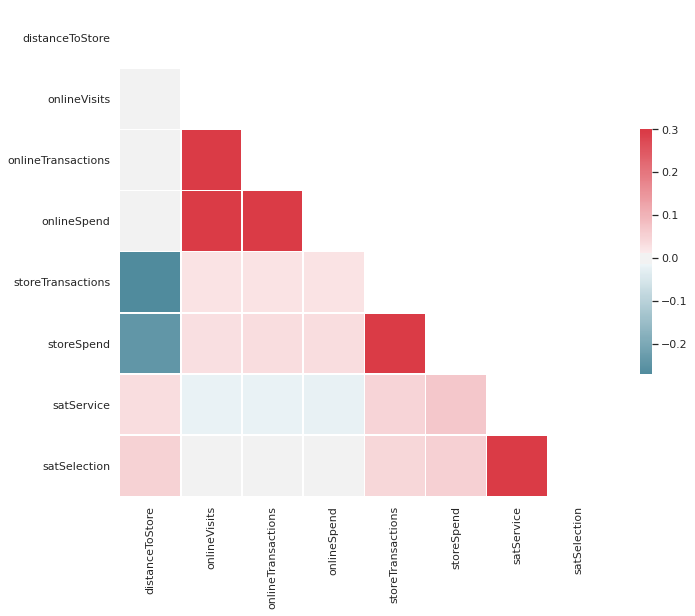

In [25]:
sns.set(style="white")

# Compute the correlation matrix
corr = df_cust.iloc[:,[2,3,5,6,7,8,9,10,11]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Transforming variables before Computing Correlation
The correlation might not be linear but might exist anyway -- check by transforming the variables first

0.26072755889066346

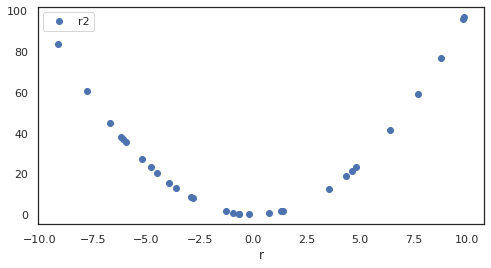

In [26]:
# As an example, this random uniform variable is very correlated with it's
# own square, but the correlation coefficient is small.
r = np.random.uniform(high=10,low=-10,size=30)
pd.DataFrame({'r':r, 'r2':np.power(r,2)}).plot(x='r',y='r2', style='bo')
np.corrcoef(r, np.power(r,2))[0][1]

In [27]:
# Let's try linear, then various transformations of distanceToStore and storeSpend
print('linear: {}'.format(np.corrcoef(df_cust.distanceToStore, df_cust.storeSpend)[0][1])) #linear
print('inverse distance: {}'.format(np.corrcoef(1/df_cust.distanceToStore, df_cust.storeSpend)[0][1])) #inverse of distanceToStore
print('inverse of sqrt distance: {}'.format(np.corrcoef(1/np.sqrt(df_cust.distanceToStore), df_cust.storeSpend)[0][1])) #inverse of sqrt(distanceToStore)


linear: -0.24353621935292497
inverse distance: 0.5266187053403761
inverse of sqrt distance: 0.5627457754888812


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 0, '1 / sqrt(distanceToStore)')

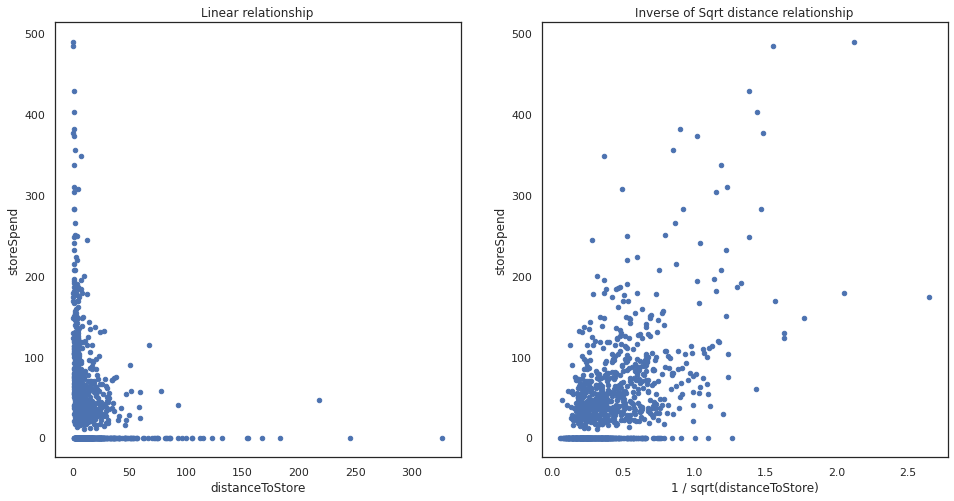

In [28]:
# This makes a difference for plotting scattercharts too.
fig, axes = plt.subplots(nrows=1, ncols=2,
                            sharex=False, sharey=False,
                            figsize=(16, 8))     # returns fig and array of axes
df_copy = df_cust.copy()
df_copy.storeSpend = df_copy.storeSpend
df_copy.distanceToStore = 1/np.sqrt(df_copy.distanceToStore)
df_cust.plot.scatter(x='distanceToStore', y='storeSpend', title='Linear relationship', ax=axes[0])
df_copy.plot.scatter(x='distanceToStore', y='storeSpend', title='Inverse of Sqrt distance relationship', ax=axes[1])
axes[1].set_xlabel('1 / sqrt(distanceToStore)')

### Typical marketing data transformations
* Unit sales, revenue, household income, price:     log(x)
* Distance:  1/x, 1/x^2, log(x)
* Market or preference share based on a utility value: e^x/(1+e^x)
* Right-tailed distributions (generally): sqrt(x) or log(x) (watch out for log(x<=0))
* Left-tailed distributions (generally): x^2

### Box-Cox Transformations
Many of the transformations above involve taking a power of x (x^2, 1/x, sqrt(x), etc.).  The Box-Cox transformation generalizes this:

y_lambda = (y^lambda - 1)/lambda       if lambda <> 0

y_lambda = log(y)                      if lambda = 0

We can use the power transform to test what the best value for lambda is:


In [29]:
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
# From this site I learn the following https://medium.com/dunder-data/from-pandas-to-scikit-learn-a-new-exciting-workflow-e88e2271ef62
#scikit-learn gotcha - sklearn requires 2-dimensional data.  A series is 1D.
#we can force Pandas to return a 1 column Dataframe as follows:
hs_distanceToStore = df_cust[['distanceToStore']].copy()
pt.fit(hs_distanceToStore)
pt.lambdas_


array([0.02236115])

Text(0.5, 1.0, 'Transformed to be more normally distributed')

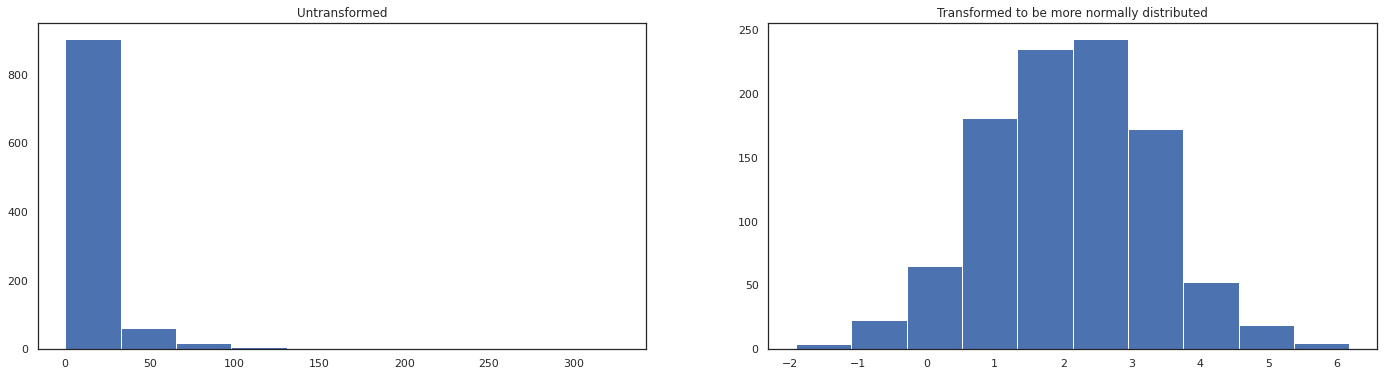

In [30]:
# the estimated lambda is above.  We can estimate this lambda and transform the data at the 
# same time with fit_transform()
transformed_distanceToStore = pt.fit_transform(hs_distanceToStore)

plt.figure(1, figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.hist(df_cust.distanceToStore)
plt.title('Untransformed')
plt.subplot(1, 2, 2)
plt.hist(transformed_distanceToStore)
plt.title('Transformed to be more normally distributed')

In [31]:
# If you try to transform a variable that is already close to normally distributed
# you will get back a lambda close to 1, which tells you you don't need to 
# transform it.  For example, age:
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
pt.fit(df_cust[['age']].copy())
pt.lambdas_

array([1.12955246])

In [32]:
# Now we can compute correlations after transforming both variables.
# You should consider transforming all variables with skewed distributions
# before computing correlations or plotting scatterplots
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
transformed_distanceToStore = pt.fit_transform(df_cust[['distanceToStore']].copy())
transformed_storeSpend = pt.fit_transform(df_cust[['storeSpend']].copy()+1) # need to add 1 so no zeros for box-cox

r, p = scipy.stats.pearsonr(transformed_distanceToStore, transformed_storeSpend)
print('corr coeff = {}\np = {}'.format(r,p))

plt.scatter(transformed_distanceToStore, transformed_storeSpend)

TypeError: No loop matching the specified signature and casting was found for ufunc add

Lambda is 0.022361147734917174


Text(0.5, 1.0, 'Transformed (by scipy) to be more normally distributed')

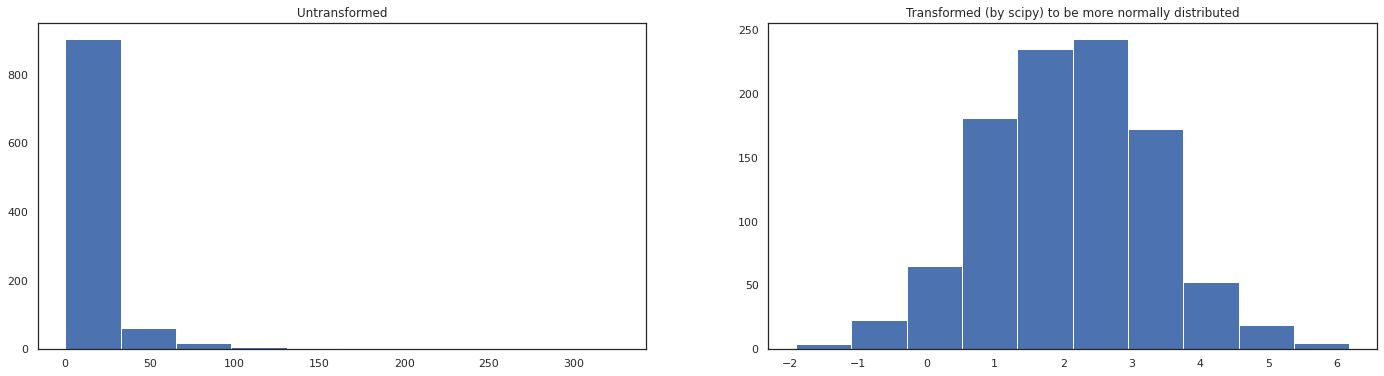

In [33]:
# Note that scipy also has a boxcox transformation routine:
# This is simpler than the scikit-learn functions above.
transformed_var, lam = scipy.stats.boxcox(x=df_cust.distanceToStore, lmbda=None, alpha=None)
print('Lambda is {}'.format(lam))
plt.figure(1, figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.hist(df_cust.distanceToStore)
plt.title('Untransformed')
plt.subplot(1, 2, 2)
plt.hist(transformed_var)
plt.title('Transformed (by scipy) to be more normally distributed')

## Exploring Associations with Survey Responses
Many marketing data sets include customer responses on surveys with discrete scale, such as a 5-point or 7-point rating scale.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


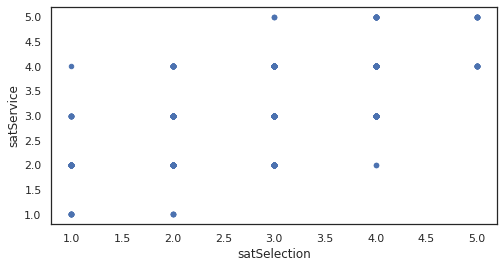

In [34]:
# As an example, plotting these datasets has the problem of overlapping dots
df_cust.plot.scatter(x='satSelection', y='satService')

In [35]:
# here is a definition of a function, jitter() which adds random noise to the data points
# so they are distiguishable.  R has a function like this
def rand_jitter(arr, extra=0):
    stdev = .01*(max(arr)-min(arr)) + extra
    return arr + np.random.randn(len(arr)) * stdev

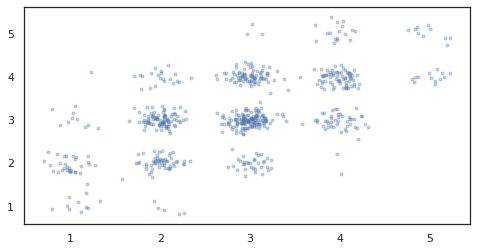

In [36]:
# use the customer jitter function:
plt.scatter(rand_jitter(df_cust.satSelection, extra=0.1), rand_jitter(df_cust.satService, extra=0.1), alpha=0.3, marker='.')

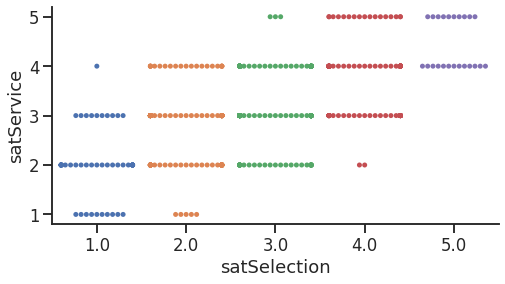

In [37]:
# seaborn has a couple of plotting options that introduce jitter (or do a mini-histogram) to help with this
sns.set(style='ticks', context='talk')

sns.swarmplot('satSelection', 'satService', data=df_cust)
sns.despine()

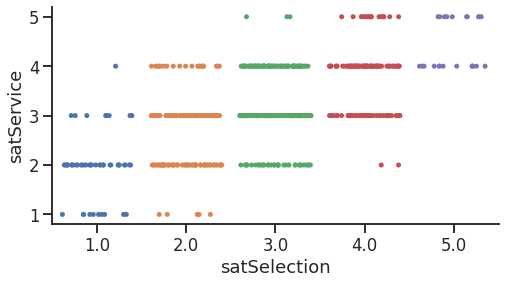

In [38]:
sns.stripplot('satSelection', 'satService', data=df_cust, jitter=0.4) # could also specify jitter=True
sns.despine()